In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

### Ad-hoc functions ###

In [17]:
#choose a proba threshold below which the model outputs 'unknown class'
def acc_threshold(proba, X, y):
    for i in np.linspace(start=0.7, stop=0.99, num=21):
        idx = np.where(np.max(proba, axis=1) > i)[0] # samples where model is confident enough given threshold
        n_classif_samples = idx.shape[0]

        #compute accuracy
        accuracy = model.score(X[idx], y[idx])
        print("With: %.3f, %g samples (%.3f of samples) classified with accuracy: %.3f" % 
          (i, n_classif_samples, n_classif_samples/y.shape[0], accuracy))

In [18]:
#displays accuracy per pump
def acc_pump(model, X, y):
    n_pump = int(max(y))
    accuracy = np.zeros(n_pump)
    for pump in range(n_pump):
        #get the labels id where label = pump
        idx = np.where(y == pump + 1)
    
        #compute accuracy
        accuracy[pump] = model.score(X[idx], y[idx])
        print("The accuracy of pump %g is: %.3f" % ((pump + 1), accuracy[pump]))
        
    plt.bar(range(1,9), height=accuracy)
    plt.show()

### Import and plot the data ###

In [4]:
# import the data
data = np.genfromtxt('no_filter.csv', delimiter=",", skip_header=1, usecols=range(1, 24), filling_values=-120)
print(data.shape)

(4123, 23)


In [6]:
#create features and labels
X = data[:,2:24]  # each feature is the signal intensity of a given beacon at a given timestep
y = data[:,0]

n_samples, n_features = X.shape

In [7]:
print(y)
print(X)

[ 2.  4.  3. ...,  7.  7.  7.]
[[ -89.  -87.  -88. ..., -120. -120. -120.]
 [-120. -120. -120. ..., -120. -120. -120.]
 [-120. -120. -120. ..., -120. -120. -120.]
 ..., 
 [ -93.  -90.  -90. ...,  -91.  -86.  -82.]
 [ -91.  -91.  -92. ...,  -88.  -88.  -85.]
 [ -91.  -89.  -92. ...,  -89.  -89.  -91.]]


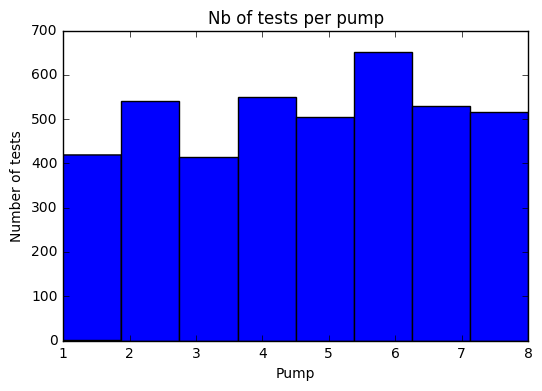

In [8]:
#plot the labels to see class balance
plt.hist(y, 8)
plt.xlabel("Pump")
plt.ylabel("Number of tests")
plt.title("Nb of tests per pump")
plt.show()

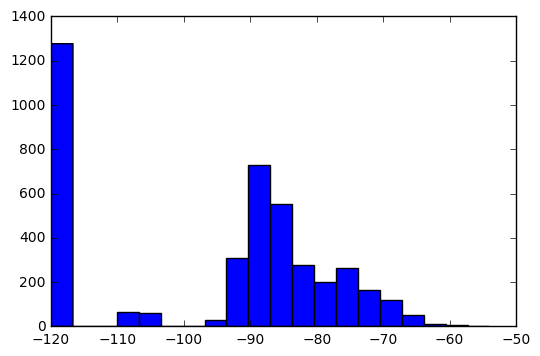

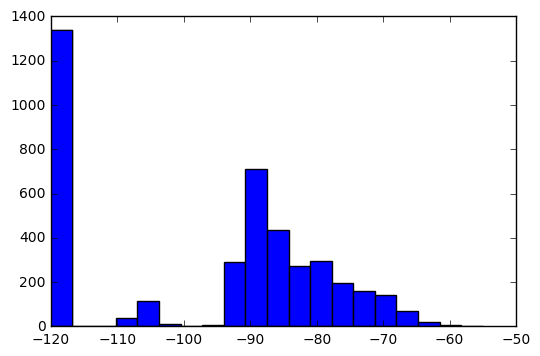

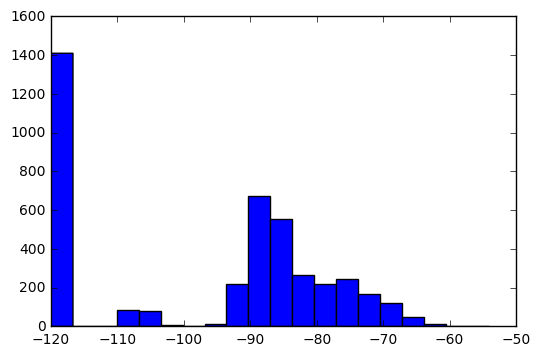

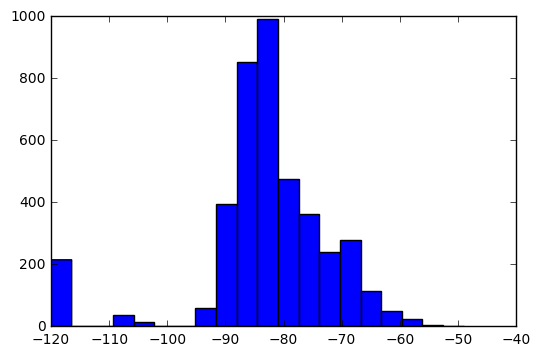

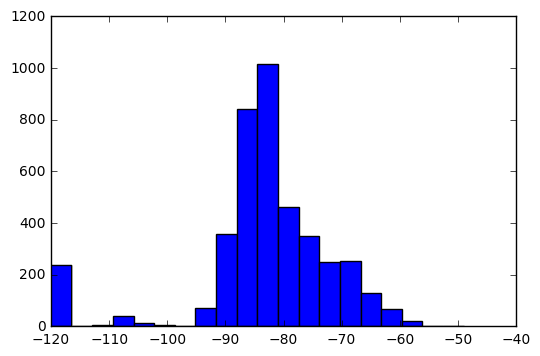

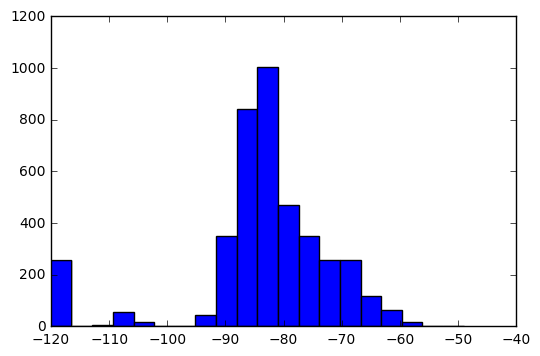

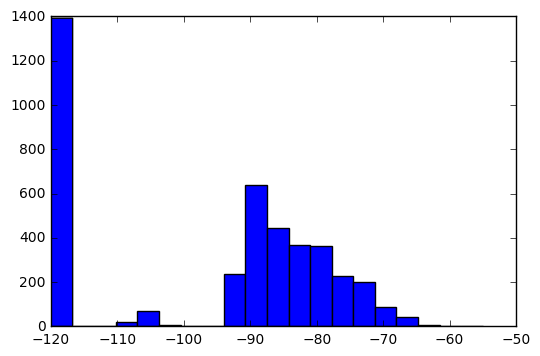

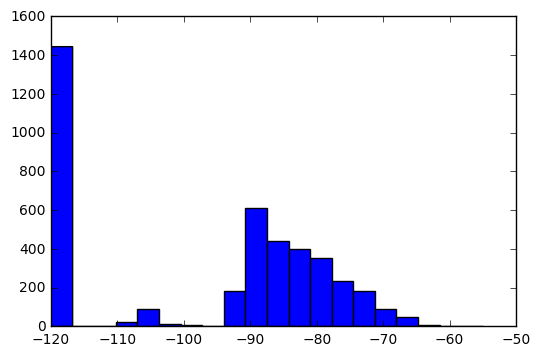

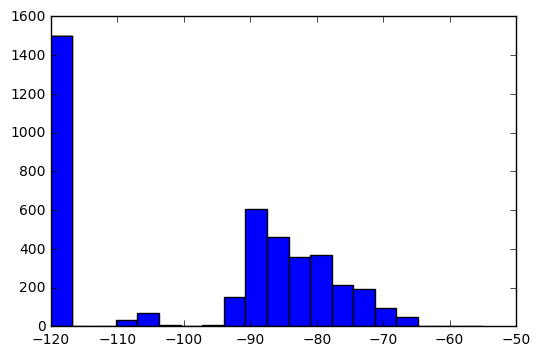

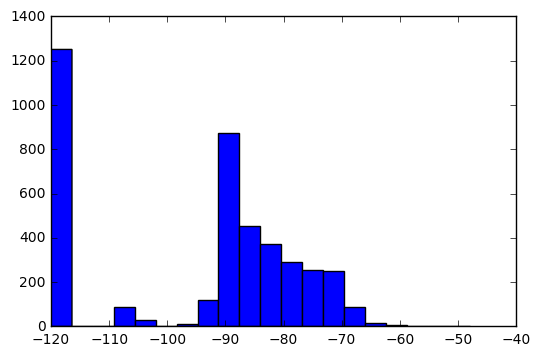

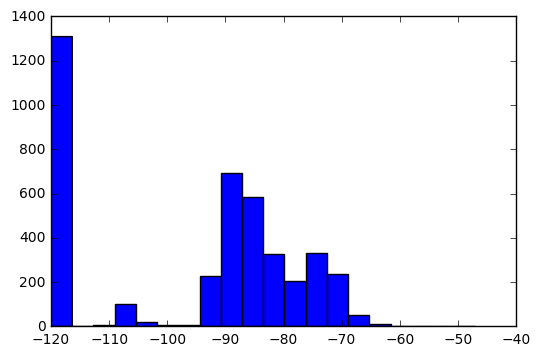

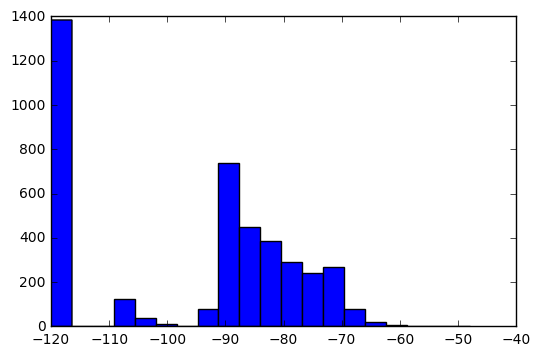

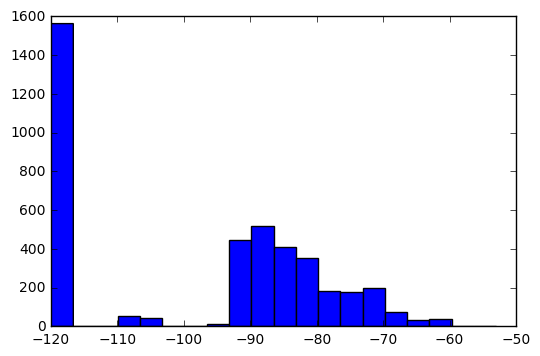

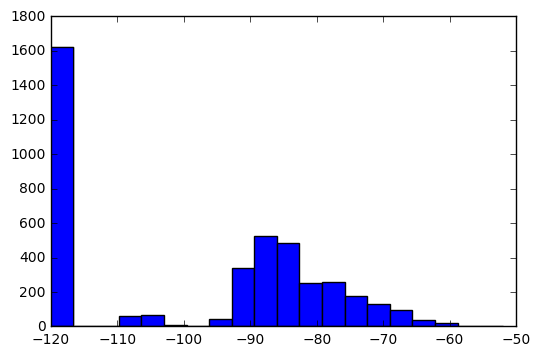

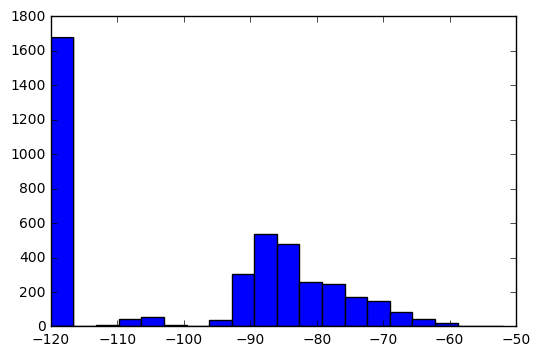

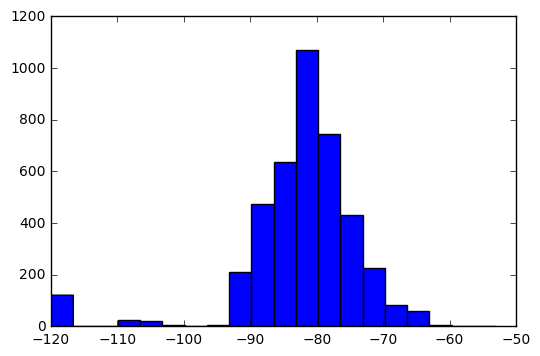

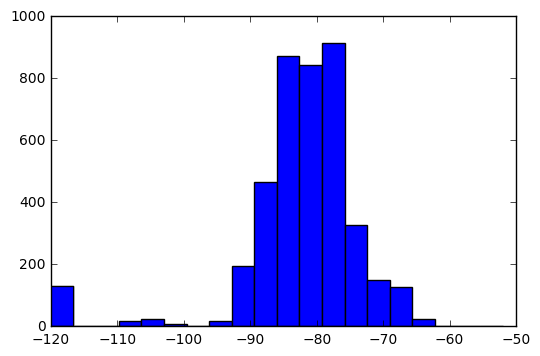

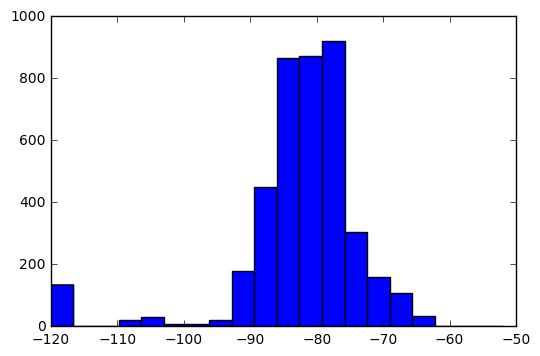

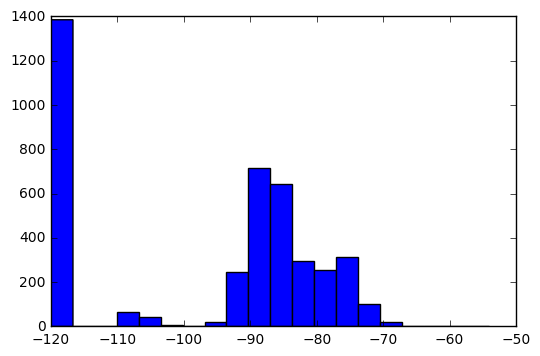

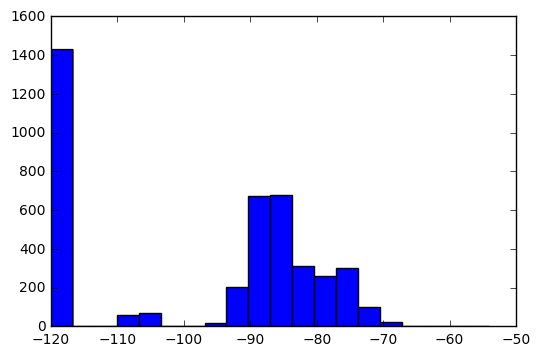

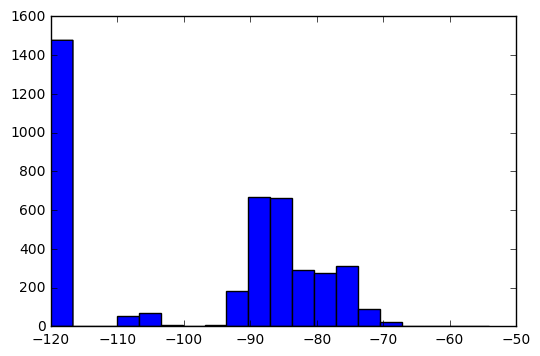

In [9]:
#plot the features distribution
for i in range(X.shape[1]):
    plt.hist(X[:,i], 20)
    plt.show()

In [10]:
#split the data for training and testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

n_test_samples = y_test.shape[0]

In [11]:
#take the log and standardise the data
from sklearn import preprocessing

X_train = np.log(np.abs(X_train))

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

X_test = np.log(np.abs(X_test))
X_test = scaler.transform(X_test)

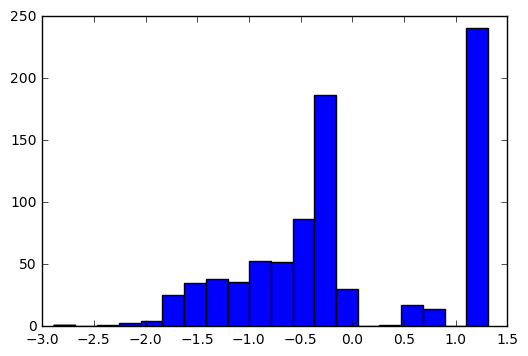

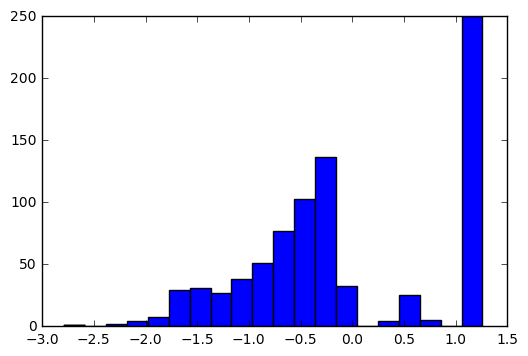

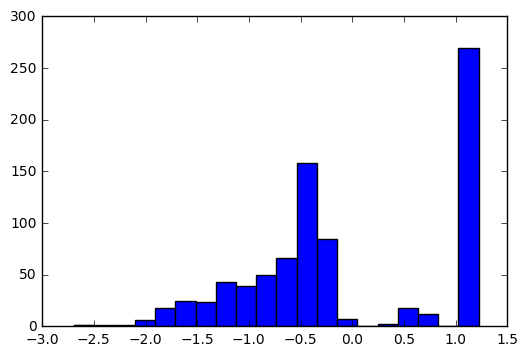

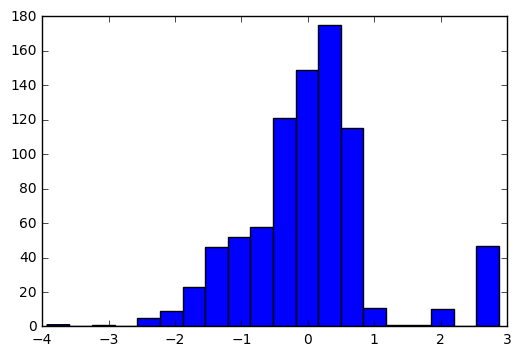

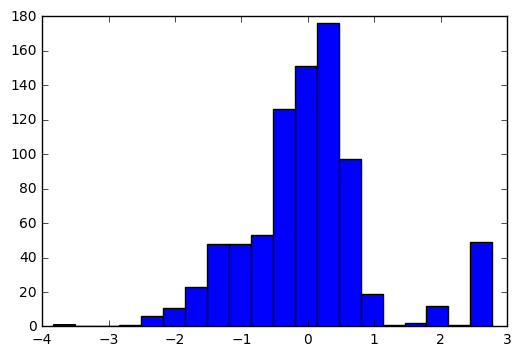

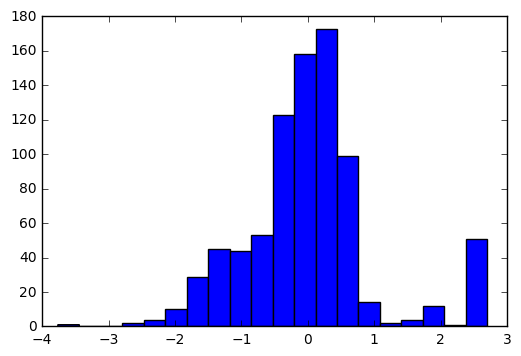

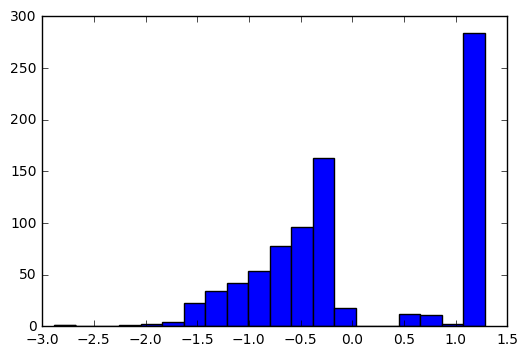

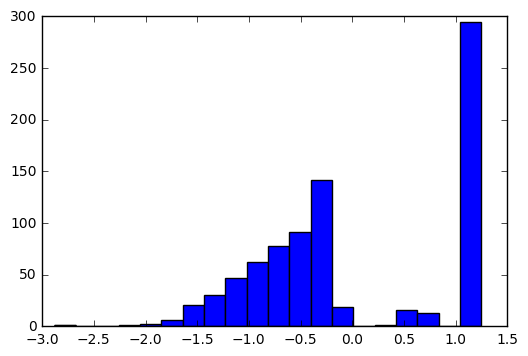

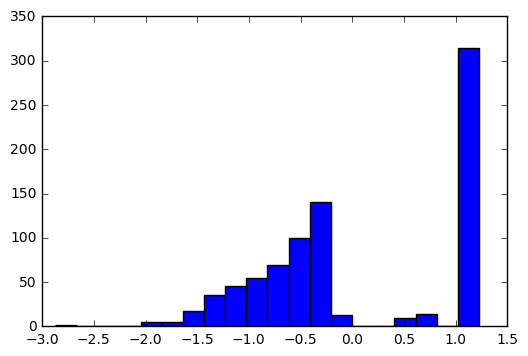

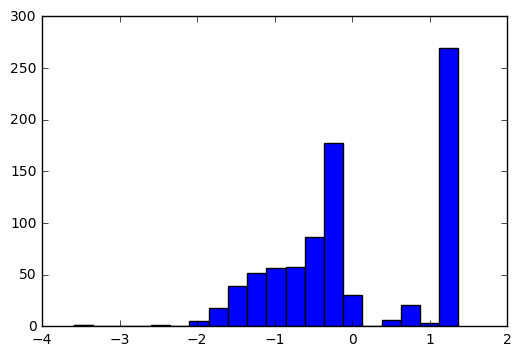

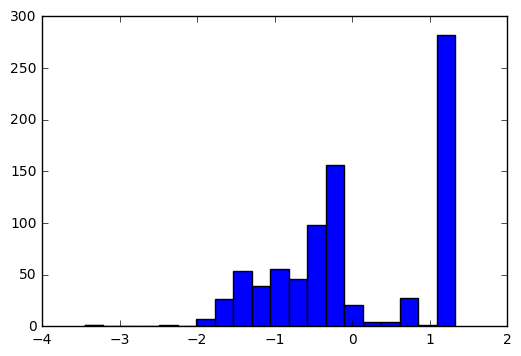

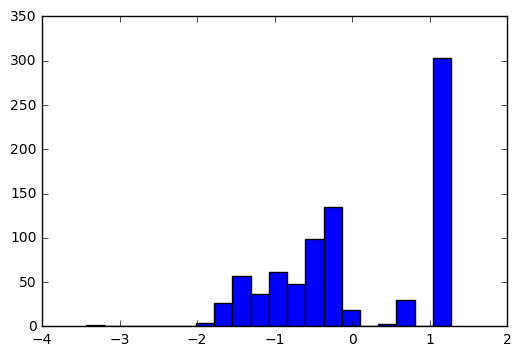

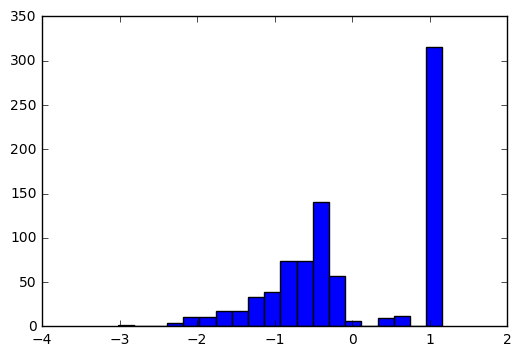

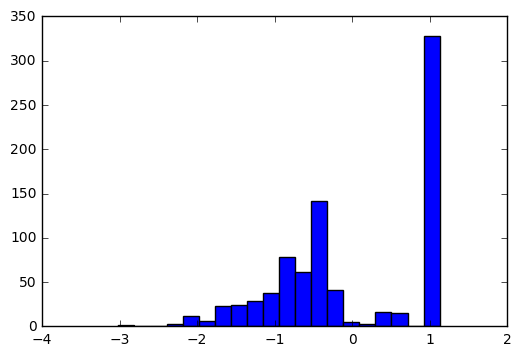

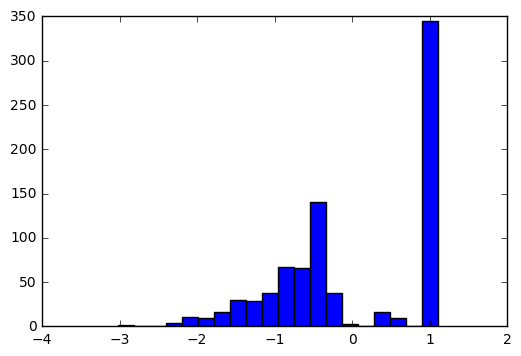

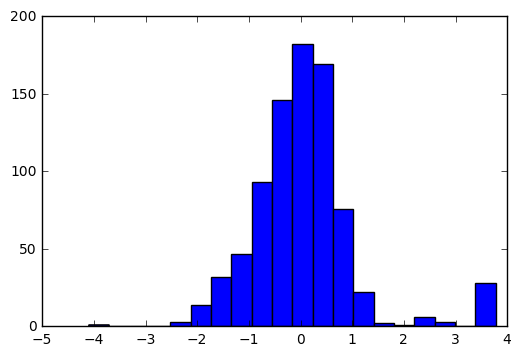

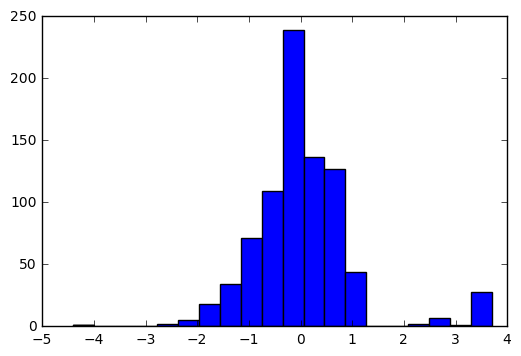

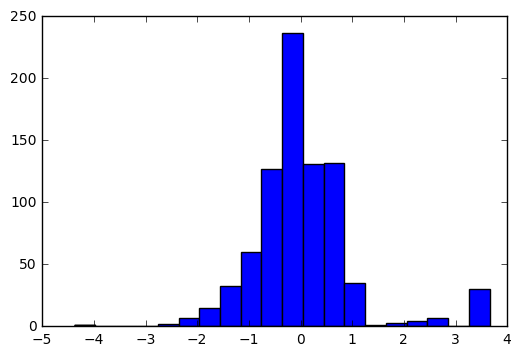

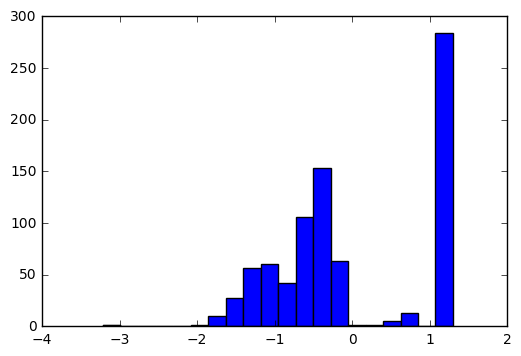

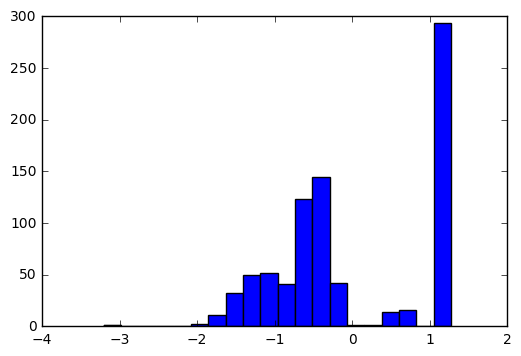

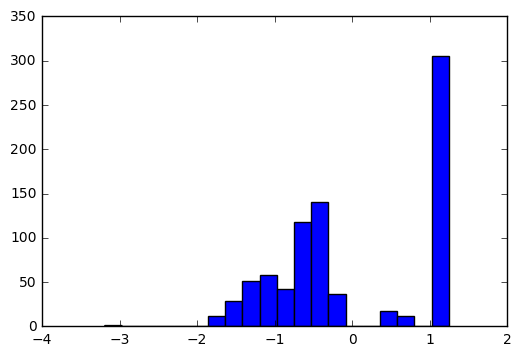

In [13]:
#plot the features distribution
for i in range(X_train.shape[1]):
    plt.hist(X_test[:,i], 20)
    plt.show()

### Train a simple linear model: logistic regression ###

In [14]:
#train a multinomial classification
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train, y_train)

print("training score : %.3f (%s)" % (model.score(X_train, y_train), 'multinomial'))

#evaluate model on test set
print("testing score : %.3f (%s)" % (model.score(X_test, y_test), 'multinomial'))

predictions = model.predict(X_test)

training score : 0.942 (multinomial)
testing score : 0.933 (multinomial)


In [19]:
proba = model.predict_proba(X_test)
acc_threshold(proba, X=X_test, y=y_test)

With: 0.700, 751 samples (0.000 of samples) classified with accuracy: 0.960
With: 0.714, 751 samples (0.000 of samples) classified with accuracy: 0.960
With: 0.729, 745 samples (0.000 of samples) classified with accuracy: 0.960
With: 0.743, 737 samples (0.000 of samples) classified with accuracy: 0.963
With: 0.758, 728 samples (0.000 of samples) classified with accuracy: 0.963
With: 0.772, 718 samples (0.000 of samples) classified with accuracy: 0.962
With: 0.787, 716 samples (0.000 of samples) classified with accuracy: 0.962
With: 0.801, 706 samples (0.000 of samples) classified with accuracy: 0.963
With: 0.816, 695 samples (0.000 of samples) classified with accuracy: 0.967
With: 0.831, 682 samples (0.000 of samples) classified with accuracy: 0.966
With: 0.845, 670 samples (0.000 of samples) classified with accuracy: 0.967
With: 0.859, 657 samples (0.000 of samples) classified with accuracy: 0.968
With: 0.874, 646 samples (0.000 of samples) classified with accuracy: 0.969
With: 0.888,

The accuracy of pump 1 is: 0.964
The accuracy of pump 2 is: 0.941
The accuracy of pump 3 is: 0.988
The accuracy of pump 4 is: 0.958
The accuracy of pump 5 is: 0.892
The accuracy of pump 6 is: 0.985
The accuracy of pump 7 is: 0.863
The accuracy of pump 8 is: 0.882


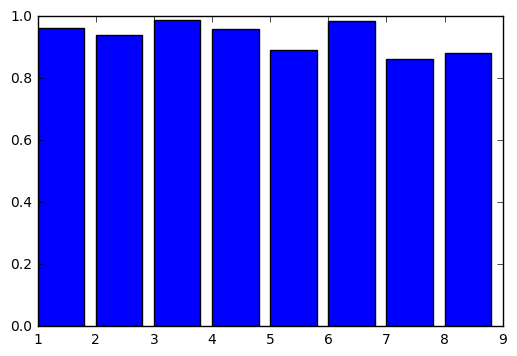

In [20]:
acc_pump(model=model, X=X_test, y=y_test)

### Train a cross validated SVM ###

In [21]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
n_test_samples = y_test.shape[0]

#take the log value of the absolute value of features
X_train = np.log(np.abs(X_train))
X_test = np.log(np.abs(X_test))

estimator = [('scaler', preprocessing.StandardScaler()), ('clf', SVC(probability = True))]
pipe = Pipeline(estimator)

param_grid = {'clf__C': [1], 'clf__gamma': [0.1], 'clf__kernel': ['rbf']}

model = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring='accuracy', verbose=1)
model.fit(X_train, y_train) 

pred_svm = model.predict(X_test)

print(model.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.2s finished


{'clf__gamma': 0.1, 'clf__C': 1, 'clf__kernel': 'rbf'}


In [22]:
print("training score : %.4f" % (model.score(X_train, y_train)))
print("testing score : %.4f" % (model.score(X_test, y_test)))

training score : 0.9651
testing score : 0.9479


In [26]:
proba_svm = model.predict_proba(X_test)

acc_threshold(proba_svm, X=X_test, y=y_test)

With: 0.700, 774 samples (0.000 of samples) classified with accuracy: 0.970
With: 0.714, 771 samples (0.000 of samples) classified with accuracy: 0.970
With: 0.729, 768 samples (0.000 of samples) classified with accuracy: 0.973
With: 0.743, 768 samples (0.000 of samples) classified with accuracy: 0.973
With: 0.758, 765 samples (0.000 of samples) classified with accuracy: 0.974
With: 0.772, 761 samples (0.000 of samples) classified with accuracy: 0.975
With: 0.787, 759 samples (0.000 of samples) classified with accuracy: 0.975
With: 0.801, 753 samples (0.000 of samples) classified with accuracy: 0.976
With: 0.816, 748 samples (0.000 of samples) classified with accuracy: 0.977
With: 0.831, 738 samples (0.000 of samples) classified with accuracy: 0.980
With: 0.845, 733 samples (0.000 of samples) classified with accuracy: 0.980
With: 0.859, 723 samples (0.000 of samples) classified with accuracy: 0.979
With: 0.874, 712 samples (0.000 of samples) classified with accuracy: 0.982
With: 0.888,

The accuracy of pump 1 is: 0.952
The accuracy of pump 2 is: 0.966
The accuracy of pump 3 is: 0.975
The accuracy of pump 4 is: 0.979
The accuracy of pump 5 is: 0.931
The accuracy of pump 6 is: 0.985
The accuracy of pump 7 is: 0.889
The accuracy of pump 8 is: 0.903


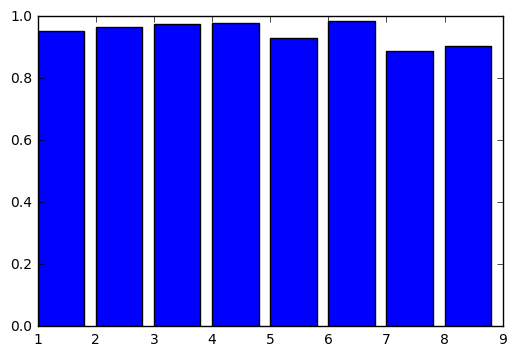

In [27]:
acc_pump(model=model, X=X_test, y=y_test)

### Train a cross validated NN ###

In [28]:
from sklearn.neural_network import MLPClassifier

#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
n_test_samples = y_test.shape[0]

#take the log value of the absolute value of features
X_train = np.log(np.abs(X_train))
X_test = np.log(np.abs(X_test))

estimator = [('scaler', preprocessing.StandardScaler()), ('clf', MLPClassifier(max_iter=200))]
pipe = Pipeline(estimator)

param_grid = {'clf__solver': ['lbfgs'], 'clf__alpha': [1e-5], 
              'clf__hidden_layer_sizes': [3, 4, 5, [5, 5], [10, 10], [5, 10, 5]]}

nn_model = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring='accuracy', verbose=1)
nn_model.fit(X_train, y_train) 
    
pred_nn = nn_model.predict(X_test)

print(nn_model.best_params_)

print("training score : %.4f" % (model2.score(X_train, y_train)))
print("testing score : %.4f" % (model2.score(X_test, y_test)))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   23.5s finished


{'clf__hidden_layer_sizes': 5, 'clf__solver': 'lbfgs', 'clf__alpha': 1e-05}


NameError: name 'model2' is not defined

In [30]:
proba_nn = nn_model.predict_proba(X_test)

acc_threshold(proba_nn, X=X_test, y=y_test)

With: 0.700, 777 samples (0.000 of samples) classified with accuracy: 0.958
With: 0.714, 776 samples (0.000 of samples) classified with accuracy: 0.959
With: 0.729, 771 samples (0.000 of samples) classified with accuracy: 0.958
With: 0.743, 769 samples (0.000 of samples) classified with accuracy: 0.958
With: 0.758, 760 samples (0.000 of samples) classified with accuracy: 0.958
With: 0.772, 756 samples (0.000 of samples) classified with accuracy: 0.958
With: 0.787, 744 samples (0.000 of samples) classified with accuracy: 0.958
With: 0.801, 742 samples (0.000 of samples) classified with accuracy: 0.960
With: 0.816, 737 samples (0.000 of samples) classified with accuracy: 0.963
With: 0.831, 733 samples (0.000 of samples) classified with accuracy: 0.963
With: 0.845, 728 samples (0.000 of samples) classified with accuracy: 0.964
With: 0.859, 724 samples (0.000 of samples) classified with accuracy: 0.965
With: 0.874, 713 samples (0.000 of samples) classified with accuracy: 0.965
With: 0.888,

The accuracy of pump 1 is: 0.964
The accuracy of pump 2 is: 0.933
The accuracy of pump 3 is: 0.914
The accuracy of pump 4 is: 0.937
The accuracy of pump 5 is: 0.902
The accuracy of pump 6 is: 0.985
The accuracy of pump 7 is: 0.855
The accuracy of pump 8 is: 0.860


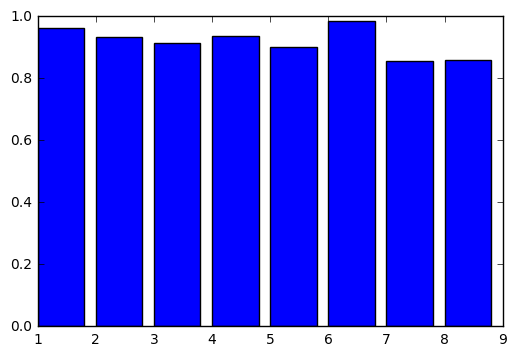

In [31]:
acc_pump(model=nn_model, X=X_test, y=y_test)

### Model Averaging ###

In [32]:
#find samples similarly classified by both models
idx1 = np.where(pred_svm == pred_nn)

global_correct = sum(y_test[idx1] == pred_svm[idx1])
global_accuracy = global_correct/idx1[0].shape

print("Testing accuracy: %.3f" % global_accuracy)
print("%.3f testing samples classified" % (idx1[0].shape[0] / n_test_samples))

Testing accuracy: 0.000
0.000 testing samples classified


The accuracy of pump 1 is: 0.988
The accuracy of pump 2 is: 0.955
The accuracy of pump 3 is: 0.933
The accuracy of pump 4 is: 0.946
The accuracy of pump 5 is: 0.928
The accuracy of pump 6 is: 0.940
The accuracy of pump 7 is: 0.952
The accuracy of pump 8 is: 0.943


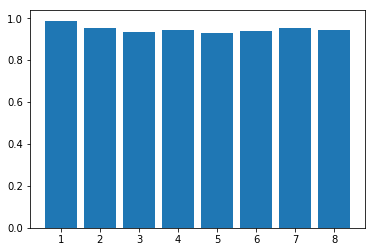

In [1009]:
n_pump = int(max(y_test))
accuracy = np.zeros(n_pump)
for pump in range(n_pump):
    #get the labels id where label = pump
    idx = np.where(y_test[idx1] == pump + 1)
    
    #compute accuracy
    accuracy[pump] = sum(pred_svm[idx] == y_test[idx])/idx[0].shape
    print("The accuracy of pump %g is: %.3f" % ((pump + 1), accuracy[pump]))
        
plt.bar(range(1,9), height=accuracy)
plt.show()

In [1050]:
#choose a proba threshold below which the model outputs 'unknown class'
for i in np.linspace(start=0.7, stop=0.99, num=21):
    id_svm = np.where(np.max(proba_svm, axis=1) > i)[0]
    id_nn = np.where(np.max(proba_nn, axis=1) > i)[0]
    idx2 = list(set(id_svm).intersection(id_nn))
    idx = list(set(idx1[0]).intersection(idx2))
    n_classif_samples = len(idx)
    
    correct = sum(y_test[idx] == pred_svm[idx])
    accuracy = correct/n_classif_samples
    
    print("With: %.3f, %g samples (%.3f of samples) classified with accuracy: %.3f" % 
          (i, n_classif_samples, n_classif_samples/y_test.shape[0], accuracy))

With: 0.700, 730 samples (0.885 of samples) classified with accuracy: 0.973
With: 0.714, 730 samples (0.885 of samples) classified with accuracy: 0.973
With: 0.729, 728 samples (0.882 of samples) classified with accuracy: 0.974
With: 0.743, 726 samples (0.880 of samples) classified with accuracy: 0.974
With: 0.758, 719 samples (0.872 of samples) classified with accuracy: 0.975
With: 0.772, 713 samples (0.864 of samples) classified with accuracy: 0.976
With: 0.787, 709 samples (0.859 of samples) classified with accuracy: 0.976
With: 0.801, 702 samples (0.851 of samples) classified with accuracy: 0.979
With: 0.816, 696 samples (0.844 of samples) classified with accuracy: 0.980
With: 0.831, 684 samples (0.829 of samples) classified with accuracy: 0.982
With: 0.845, 674 samples (0.817 of samples) classified with accuracy: 0.982
With: 0.859, 661 samples (0.801 of samples) classified with accuracy: 0.982
With: 0.874, 652 samples (0.790 of samples) classified with accuracy: 0.982
With: 0.888,